In [6]:
import allel
import malariagen_data
import pandas as pd
import numpy as np
%matplotlib inline
import probe
import json
import locusPocus
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "odds_ratio":np.exp(coeff),
                               "conf_lower":np.exp(conf_lower),
                               "conf_higher":np.exp(conf_higher)
                                })
    
    results_df.loc[:, 'sig'] = ['significant' if pval <= 0.05 else 'not significant' for pval in pvals]

    #Reordering...
    results_df = results_df[["odds_ratio","pvals","conf_lower","conf_higher", "sig"]]
    return results_df

In [8]:
def plot_ors(ax, df, last=False):
    
#     df['odds_lower'] = df['odds_ratio'] - df['odds_lower']
#     df['odds_upper'] = df['odds_upper'] - df['odds_ratio']
        
    ax.errorbar(x=df['odds_ratio'], 
                y=df['index'].to_list(), 
                xerr=(df['odds_lower'].to_list(), 
                      df['odds_upper'].to_list()),
                color='dimgrey',  linewidth=2, capsize=4, linestyle='None',
                marker="o", markersize=10, mfc="dimgrey", mec="black")
    ax.set_xlim(0.5,3)
    ax.set_ylim(0,2)
    ax.axvline(x=1, linewidth=1, linestyle='--', color='black')
    ax.tick_params(axis='both', which='major', labelsize=8)

    if last == False:
        ax.set_xlabel('', fontsize=8)
        ax.set_xticks([])
        sns.despine(ax=ax, bottom=False, left=True)
    if last == True:
        ax.set_xlabel('', fontsize=8)
        ax.set_xticks(np.arange(0.5,3, 0.5))
        sns.despine(ax=ax, bottom=False, left=True)
        ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=10)

    ax.set_yticklabels("")
    ax.set_yticks([])

    plt.tight_layout()

In [81]:
df = pd.DataFrame({'odds_ratio': [1.156, 1.616],
             'odds_upper': [1.503, 2.363],
             'odds_lower': [0.889, 1.104],
             'insecticide':['Deltamethrin', 'Pirimiphos-methyl']
             })

df['odds_lower'] = df['odds_ratio'] - df['odds_lower']
df['odds_upper'] = df['odds_upper'] - df['odds_ratio']
df['index'] = [0.5, 1.5]
    
df

,odds_ratio,odds_upper,odds_lower,insecticide,index
0,1.156,0.347,0.267,Deltamethrin,0.5
1,1.616,0.747,0.512,Pirimiphos-methyl,1.5


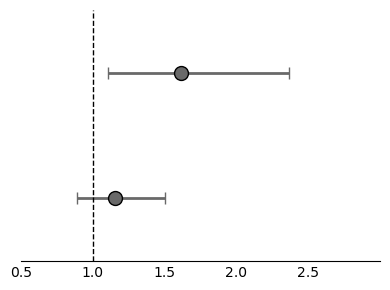

In [89]:
fig, ax = plt.subplots(1,1, figsize=[4,3])

plot_ors(ax=ax, df=df, last=True)

# CNV association tests - *Coeae1f*

In [9]:
sample_sets = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    #tz gaard
   # '1246-VO-TZ-KABULA-VMF00185',
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [4]:
contig= '2L'

coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28540000-28560000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

name = 'coeae1f'

In [10]:
ag3 = malariagen_data.Ag3(pre=True)
#clusters_df, clusters_idxs, palette = locusPocus.load_cluster_data()

### individual-level haplotype association tests

In [147]:
ds_cnv = ag3.gene_cnv(region='AGAP006227', sample_sets=sample_sets)

Load CNV HMM data:   0%|          | 0/306 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

In [149]:
cnv_df = pd.DataFrame({'sample_id':ds_cnv['sample_id'].values, 'cn_mode':ds_cnv['CN_mode'].values[0]})

In [150]:
cnv_df.to_csv("../../coeae1f_cnvs.tsv", sep="\t")

In [14]:
def load_phenotypes(sample_sets):
    df_samples = ag3.sample_metadata(sample_sets)
    gaard_west_phenos = pd.read_csv("/home/sanj/Projects/gaard/config/gaard_metadata.tsv", sep="\t", index_col=0)[['partner_sample_id', 'insecticide', 'phenotype']]
    #gaard_east_phenos = pd.read_csv("../../sample_phenotypes_EA.csv", sep="\t").rename(columns={'specimen':'partner_sample_id'})[['partner_sample_id', 'insecticide', 'phenotype']]
    cnv_df = pd.read_csv("../../coeae1f_cnvs.tsv", sep="\t", index_col=0)
    #karyo_df = pd.read_csv("../../karyotypes.tsv", sep="\t", index_col=0).rename(columns={'partner_sample_id':'sample_id'})
    #phenos = pd.concat([gaard_west_phenos, gaard_east_phenos], axis=0)
    return phenos.merge(df_samples).merge(cnv_df)#.merge(karyo_df)

In [15]:
df_glm_pheno = load_phenotypes(sample_sets)

NameError: name 'phenos' is not defined

In [12]:
df_glm_pheno.shape

(828, 33)

In [13]:
df_glm_pheno.country.unique()

array(['Ghana', 'Togo', 'Benin', "Cote d'Ivoire"], dtype=object)

#### Needin DF
- CNV modal copy number
- Phenotype
- Location
- Species

### Find CNV Tagging snps

In [9]:
# cnv_pos_gambiae = cnv_df.query("cn_mode > 2").sample_id
# cnv_neg_gambiae = cnv_df.query("cn_mode > 2").sample_id

# countries = ["Ghana", "Cote d'Ivoire"]

# df_wa_gam = df_glm_pheno.query(f'country in {countries} and taxon == "gambiae"')

# wa_gam_cnv = df_wa_gam.query("cn_mode > 5").sample_id.to_list()
# wa_gam_no_cnv = df_wa_gam.query("cn_mode <= 2").sample_id.to_list()

# wa_gam_cnv_snps = ag3.snp_calls(region='2L:28,540,000-28,560,000', sample_query=f"sample_id in {wa_gam_cnv}", site_mask='gamb_colu')
# wa_gam_nocnv_snps = ag3.snp_calls(region='2L:28,540,000-28,560,000', sample_query=f"sample_id in {wa_gam_no_cnv}", site_mask='gamb_colu')

# wa_gam_cnv_gn = allel.GenotypeDaskArray(wa_gam_cnv_snps['call_genotype'].data).compute()
# wa_gam_nocnv_gn = allel.GenotypeDaskArray(wa_gam_nocnv_snps['call_genotype'].data).compute()

# wa_gam_cnv_ac = wa_gam_cnv_gn.count_alleles(max_allele=3)
# wa_gam_nocnv_ac = wa_gam_nocnv_gn.count_alleles(max_allele=3)

# loc_private_alleles = allel.locate_private_alleles(wa_gam_cnv_ac, wa_gam_nocnv_ac)

# pos = wa_gam_cnv_snps['variant_position'].values

# loc_private_alleles

In [10]:
df_glm_pheno[['taxon', 'phenotype', 'insecticide', 'cn_mode']].groupby(['taxon', 'insecticide', 'cn_mode']).value_counts().to_frame()

count
taxon      insecticide cn_mode phenotype       
arabiensis Delta       2       alive         98
                               dead          89
                       3       alive         42
                               dead          20
                       4       alive         15
                               dead           8
                       5       alive          6
                               dead           3
                       6       alive          1
           PM          2       alive         20
                               dead          17
                       3       alive         25
                               dead          22
                       4       alive         27
                               dead          20
                       5       alive          3
                       6       alive          3
                               dead           1
coluzzii   Delta       2       dead         113
                               alive         96
           PM          2       alive         50
                               dead          43
gambiae    Delta       2       alive        132
                               dead         113
                       3       alive          1
                       5       alive         15
                               dead           6
                       6       dead           2
                               alive          1
                       8       alive          1
                               dead           1
           PM          2       alive        133
                               dead          90
                       3       alive          4
                               dead           1
                       5       alive         21
                               dead           4
                       6       dead           1

#### Expected Dead v Alive for 
- Taxon / insecticide

In [42]:
df = df_glm_pheno

In [43]:
has_cnv_df = df.query("cn_mode > 2")
no_cnv_df = df.query("cn_mode <= 2")

In [44]:
counts_df = df[['taxon', 'phenotype', 'insecticide']].groupby(['taxon', 'insecticide']).value_counts().to_frame()
counts_cnv_df = has_cnv_df[['taxon', 'phenotype', 'insecticide']].groupby(['taxon', 'insecticide']).value_counts().to_frame().rename(columns={'count':'counts_no_cnv'})
counts_no_cnv_df = no_cnv_df[['taxon', 'phenotype', 'insecticide']].groupby(['taxon', 'insecticide']).value_counts().to_frame().rename(columns={'count':'counts_cnv'})

In [45]:
no_cnv_pheno_freqs = no_cnv_df[['taxon', 'phenotype', 'insecticide']].groupby(['taxon', 'insecticide']).value_counts(normalize=True).mul(100).to_frame().rename(columns={'proportion':'proportion_no_cnv'})
has_cnv_pheno_freqs = has_cnv_df[['taxon', 'phenotype', 'insecticide']].groupby(['taxon', 'insecticide']).value_counts(normalize=True).mul(100).to_frame().rename(columns={'proportion':'proportion_cnv'})
pheno_df = pd.concat([counts_df, counts_no_cnv_df, counts_cnv_df, no_cnv_pheno_freqs, has_cnv_pheno_freqs], axis=1)

In [154]:
pheno_df.head(4)

count  counts_cnv  counts_no_cnv   
taxon      insecticide phenotype                                     
arabiensis Delta       alive        162          98           64.0  \
                       dead         120          89           31.0   
           PM          alive         78          20           58.0   
                       dead          60          17           43.0   

                                  proportion_no_cnv  proportion_cnv  
taxon      insecticide phenotype                                     
arabiensis Delta       alive              52.406417       67.368421  
                       dead               47.593583       32.631579  
           PM          alive              54.054054       57.425743  
                       dead               45.945946       42.574257

### plotting expected mortality

In [165]:
pheno_long_df = pheno_df.reset_index().melt(id_vars=['taxon', 'insecticide', 'phenotype'], value_vars=['proportion_cnv', 'proportion_no_cnv'], var_name='cnv_status')

In [166]:
df = pheno_long_df.groupby(['taxon', 'insecticide', 'phenotype', 'cnv_status']).agg('sum')

In [167]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [168]:
import matplotlib.ticker as ticker

In [205]:
def plot_ors(ax, df, last=False):
    df3 = df.reset_index().query("index == 'cn_mode'")
    df3['conf_lower2'] = df3['odds_ratio'] - df3['conf_lower']
    df3['conf_higher2'] =  df3['conf_higher'] - df3['odds_ratio']

    ax.errorbar(x=df3.iloc[::-1]['odds_ratio'], y=df3.iloc[::-1]['index'], 
                     xerr=(df3.iloc[::-1]['conf_lower2'].to_list(), df3.iloc[::-1]['conf_higher2'].to_list()),
                color='dimgrey',  linewidth=2, capsize=4, linestyle='None',
                marker="o", markersize=10, mfc="dimgrey", mec="black")
    ax.set_xlim(0,10)
    ax.axvline(x=1, linewidth=1, linestyle='--', color='black')
    ax.tick_params(axis='both', which='major', labelsize=8)

    if last == False:
        ax.set_xlabel('', fontsize=8)
        ax.set_xticks([])
        sns.despine(ax=ax, bottom=False, left=True)
    if last == True:
        ax.set_xlabel('', fontsize=8)
        ax.set_xticks(np.arange(0,10, 2))
        sns.despine(ax=ax, bottom=False, left=True)
        ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=10)

    ax.set_yticklabels("")
    ax.set_yticks([])

    plt.tight_layout()

In [187]:
pheno_long_df = pheno_long_df.sort_values('phenotype', ascending=False)
pheno_long_df = pheno_long_df.assign(phenotype=pd.factorize(pheno_long_df.phenotype)[0])

gambiae PM
gambiae PM
gambiae Delta
gambiae Delta


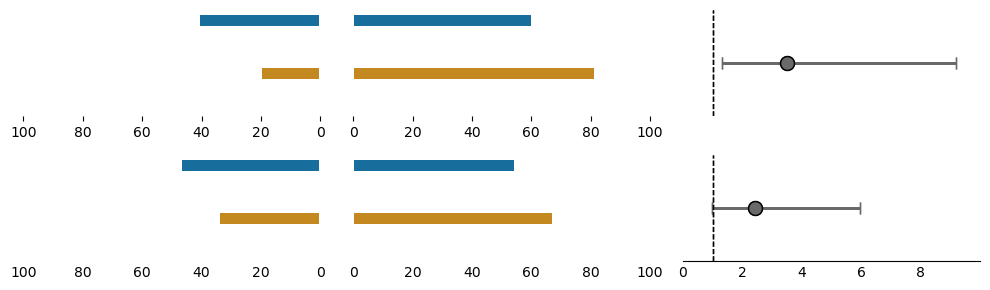

arabiensis PM
arabiensis PM
arabiensis Delta
arabiensis Delta


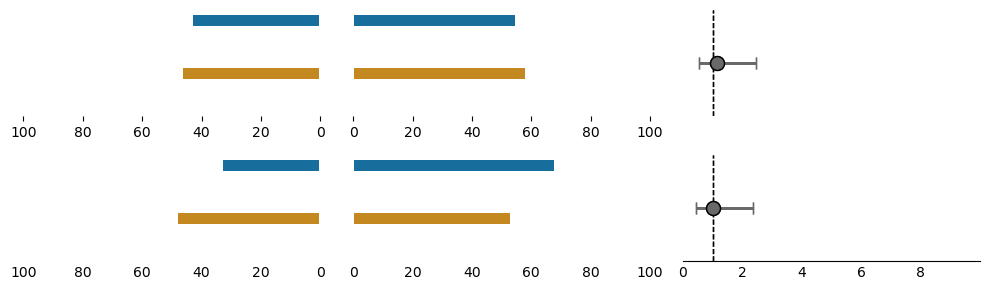

In [206]:
for tax_i, tax in enumerate(['gambiae', 'arabiensis']):
    
    fig, ax = plt.subplots(2,3,figsize=(10, 3)) #, gridspec_kw={'height_ratios':[3,3,1]})
    for ins_i, ins in enumerate(['PM', 'Delta']):
        for pheno in [0,1]:            
            if tax == "arabiensis":
                tax_i += 2
            
            print(tax, ins)
            p_df = pheno_long_df.query("taxon == @tax and insecticide == @ins and phenotype == @pheno")

            sns.barplot(p_df, y='cnv_status', x='value',ax=ax[ins_i][pheno], palette='colorblind')
            for axes in ax.flatten(): sns.despine(left=True, bottom=True, ax=axes)
            #for axes in ax.flatten(): axes.set_xticks([])
            for axes in ax.flatten(): axes.set_yticks([])
            ax[ins_i][pheno].set_ylabel("")
            ax[ins_i][pheno].set_xlabel("")
            ax[ins_i][pheno].set_xlim(0, 100)

            if pheno == 0:
                ax[ins_i][pheno].invert_xaxis()
            if pheno == 1:
                ax[ins_i][pheno].set_yticks([])
            
            change_width(ax[ins_i][pheno], 0.2)
        
            last=True if ins == 'Delta' else False
            plot_ors(ax=ax[ins_i][2], df=glm_dict[f'{tax}_{ins}'], last=last)

    for i in [0,1]:
        ax[1][i].set_xticks([0,20, 40, 60 , 80, 100])
        ax[1][i].tick_params(axis=u'both', which=u'both',length=0)

    plt.tight_layout()
    plt.show()

### phenotype glm

In [12]:
import statsmodels.formula.api as smf

In [13]:
glm_dict = {}
n_list = {}
for ins in ['PM', 'Delta']:
    for ta in ['gambiae', 'arabiensis']:
        df2 = df_glm_pheno.query("insecticide == @ins and taxon == @ta")  
        
        glm_data = df2[['location', 'cn_mode', 'phenotype', 'mean_genotype']]

#         glm_data.cn_mode[glm_data.cn_mode <= 2] = 0
#         glm_data.cn_mode[glm_data.cn_mode > 2] = 1

        pheno = pd.factorize(glm_data['phenotype'])[0].astype(int)
        glm_data = glm_data.assign(pheno=pheno)
        #glm_data['location'] = pd.factorize(glm_data['location'])[0]

        # Instantiate a binom family model with the default link function.
        #glm_data.exog = sm.add_constant(glm_data)
        
        if ta == 'arabiensis':
            formula = 'pheno ~ cn_mode + C(location)'
        elif ta == 'gambiae':
            formula = 'pheno ~ cn_mode + C(location) + mean_genotype'
        
        logit_model = smf.glm(formula=formula, data=glm_data, family=sm.families.Binomial())
        logit_results = logit_model.fit()

        print(ta, ins, logit_results.summary(), "\n")
        params = logit_results.params
        conf = logit_results.conf_int()
        conf['Odds Ratio'] = params
        conf.columns = ['5%', '95%', 'Odds Ratio']
        print(np.exp(conf), "\n\n\n\n")

        glm_dict[f"{ta}_{ins}"] = results_summary_to_dataframe(logit_results)

gambiae PM                  Generalized Linear Model Regression Results                  
Dep. Variable:                  pheno   No. Observations:                  254
Model:                            GLM   Df Residuals:                      248
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -156.32
Date:                Sat, 07 Oct 2023   Deviance:                       312.65
Time:                        22:28:17   Pearson chi2:                     255.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09082
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Interce

In [156]:
glm_dict['gambiae_PM']

,odds_ratio,pvals,conf_lower,conf_higher,sig
Intercept,8.062162,0.000088,2.839927,22.887368,significant
C(location)[T.Baguida],0.129002,0.000765,0.039139,0.425192,significant
C(location)[T.Madina_North],0.100825,0.000455,0.027958,0.363606,significant
C(location)[T.Obuasi],0.162584,0.001475,0.053059,0.498189,significant
cn_mode,3.489246,0.011339,1.326250,9.179895,significant
mean_genotype,1.092681,0.688338,0.708602,1.684939,not significant


In [157]:
glm_dict['gambiae_Delta']

,odds_ratio,pvals,conf_lower,conf_higher,sig
Intercept,1.190040,0.491413,0.724975,1.953439,not significant
C(location)[T.Madina_North],1.068032,0.829724,0.586237,1.945790,not significant
C(location)[T.Obuasi],0.437126,0.009866,0.233151,0.819554,significant
cn_mode,2.423857,0.054014,0.984843,5.965504,not significant
mean_genotype,1.220294,0.308692,0.831742,1.790361,not significant


In [158]:
glm_dict['arabiensis_PM']

,odds_ratio,pvals,conf_lower,conf_higher,sig
Intercept,1.176471,0.622257,0.616287,2.245841,not significant
cn_mode,1.146512,0.723472,0.537597,2.445120,not significant


In [159]:
glm_dict['arabiensis_Delta']

,odds_ratio,pvals,conf_lower,conf_higher,sig
Intercept,2.126883,0.056857,0.978225,4.624328,not significant
C(location)[T.Muleba],0.470116,0.070403,0.207546,1.064865,not significant
cn_mode,1.004949,0.990982,0.426886,2.365790,not significant
